Notebook con entrenamiento del modelo XGBoost con el dataframe con medias ponderadas

Autor: Mateo Turati

Descripción: Obtengo los datos de train, validación y test. Creo dos modelo de XGBoostClassifier usando  dos métodos de ajuste de hiperparámetros y estudio sus resultados

Moficaciones:
Andrés: He cambiado el codigo para que los modelos usaen la GPU para entrenar *Mateo: Ya vi que se podía hacer pero tarda más

In [ ]:
#NO BORRAR ESTA CELDA!!!!!!!!!!!!!!!!

#Marca con un * al final las que ya estén solucionadas

#Solucionar:
#Están todas la celdas de codigo seguidas sin mucha explicación, pon título y eso para separar y explica que vas a hacer y los resultados obtenidos, no solo en la conclusión

#Haz algo paracido a lo que ha hecho telmo. Su notebook está en P1 y es arbol_decision.ipynb





#Pon lo de las trasnformaciones y selección de variables antes del modelo baseline, ya que aunque no hagan falta se explica el porque.

* [Carga de los datos](#carga-de-los-datos)
* [Modelo Baseline](#modelo-baseline)
* [Transformaciones](#transformaciones)
* [Selección de variables](#selección-de-variables)
* [Ajuste de hiperparámetros](#ajuste-de-hiperparámetros)
* [Conclusiones](#conclusiones)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import mlflow

### Descripción general del notebook

En este notebook realizaremos el modelado y entrenamiento de un modelo XGBoost para predecir el ganador de una pelea utilizando datos previos. Para ello, emplearemos un dataframe con medias ponderadas de combates anteriores y variables como la racha de victorias con la que llega el luchador a la pelea, un sistema de puntos diseñado manualmente, entre otros factores.

En la fase de entrenamiento, buscaremos los hiperparámetros óptimos utilizando dos estrategias de ajuste. Para evaluar si el ajuste de hiperparámetros ha tenido un impacto positivo, primero crearemos un modelo base (baseline), a partir del cual extraeremos conclusiones iniciales y posteriormente intentaremos mejorarlo.

Para el ajuste de hiperparámetros, utilizaremos las técnicas de búsqueda en rejilla (grid search) y búsqueda aleatoria (random search). En ambos casos, seleccionaremos el modelo con el mejor F1-score utilizando validación cruzada, ya que, aunque buscamos maximizar la accuracy, queremos evitar que el modelo se enfoque únicamente en la clase mayoritaria y deje de predecir la clase minoritaria.

El objetivo principal del notebook es desarrollar un modelo con un buen desempeño que pueda ser utilizado en la fase de despliegue.

In [2]:
ruta_mlflow = os.path.abspath(os.path.join("..", "..", "..", "mlruns"))

# Configurar MLflow para guardar los modelos en esa ruta
mlflow.set_tracking_uri(f"file:///{ruta_mlflow}")

print("MLflow tracking URI:", mlflow.get_tracking_uri())  

MLflow tracking URI: file:///c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\mlruns


Para guardar los resultados de diferentes experimentos creamos un directorio mlruns donde se guardarán los modelos realizados con una breve descripción y sus resultados.

#### CARGA DE LOS DATOS

Cargamos el conjunto de train y test los cuales han sido seleccionados respetando el orden cronológico debido a que es una serie temporal. Separamos los conjuntos en X e y. En X guardamos todas las variables que puedan ser introducidas al modelo, excluyendo los nombres, la fecha y la variable respuesta. En y guardamos la variable respuesta.

In [3]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..","..", "data", "P2","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2011-01-22,Melvin Guillard,Evan Dunham,False,0.24,0.00,0.4772,0.3612,0.0000,0.4200,...,12.108597,0.000000,12,5,0.24,0.1160,-0.475248,-3.16,0.80,-185.76
1,2011-02-26,George Sotiropoulos,Dennis Siver,True,0.24,0.36,0.2548,0.2912,0.4812,0.1600,...,20.371815,17.247681,7,10,-0.12,-0.0364,0.081182,1.56,0.00,228.72
2,2011-03-19,Ricardo Almeida,Mike Pyle,True,0.00,0.24,0.5056,0.5132,0.4500,0.1368,...,12.872598,1.603038,10,5,-0.24,-0.0076,0.255163,-1.08,-0.24,238.92
3,2011-03-19,Mirko Filipovic,Brendan Schaub,True,0.24,1.00,0.3820,0.5688,0.0000,0.0000,...,0.159050,10.115785,8,4,-0.76,-0.1868,0.000000,0.88,0.00,143.08
4,2011-03-19,Dan Miller,Nate Marquardt,True,0.00,0.00,0.3032,0.3912,0.4600,0.2700,...,13.098965,2.734214,8,13,0.00,-0.0880,0.093856,-0.92,-0.40,188.52


In [4]:
ruta_test = os.path.join("..","..","..","data", "P2","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2023-02-04,Derrick Lewis,Serghei Spivac,True,0.40,0.00,0.5864,0.3636,0.1200,0.4500,...,186.452628,8.428689e+01,25,9,0.40,0.2228,-0.307248,-0.36,0.0,-136.44
1,2023-02-04,Dooho Choi,Kyle Nelson,True,0.36,0.00,0.4824,0.6552,0.0800,0.0000,...,0.000000,0.000000e+00,6,5,0.36,-0.1728,0.133333,0.00,0.0,-61.20
2,2023-02-04,Marcin Tybura,Blagoy Ivanov,False,0.00,0.00,0.4276,0.5056,0.2000,0.2792,...,141.263914,2.759667e-07,16,6,0.00,-0.0780,-0.188071,-0.40,0.0,-56.72
3,2023-02-11,Tyson Pedro,Modestas Bukauskas,True,0.60,0.00,0.6544,0.4112,0.0000,0.0000,...,27.219766,0.000000e+00,8,4,0.60,0.2432,0.000000,0.40,0.0,16.88
4,2023-02-11,Islam Makhachev,Alexander Volkanovski,False,0.36,0.24,0.6300,0.5844,0.7576,0.1200,...,324.423336,5.369947e+02,13,12,0.12,0.0456,0.130692,1.16,-0.8,5.28


In [5]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.561973
True     0.438027
Name: proportion, dtype: float64

In [6]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.550505
True     0.449495
Name: proportion, dtype: float64

Como podemos ver hay una ligera desigualdad en la distribución de la variable respuesta, esto se debe a que el peleador A suele ser el favorito.

#### MODELO BASELINE

Creo un modelo simple el cual debería conseguir mejorar tras realizar los ajustes de hiperparámetros. Para este modelo usaré los hiperparámetros por defecto de XGBoost, sin tener en cuenta los ligeros desbalances de clase ni eliminando atributos no útiles.

In [7]:
base = XGBClassifier(random_state=42)
base.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [8]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = base.predict(X_test)
y_val_prob = base.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5370370370370371
F1-Score: 0.4489
AUC-ROC: 0.5252
Precisión: 0.4828
Sensibilidad: 0.4195
Log-loss: 0.9480638146871734


El accuracy obtenido está algo por debajo al que se obtendría prediciendo siempre al favorito. Tras realizar el ajuste de hiperparámetros esperamos conseguir al menos un accuracy superior al anteriormente mencionado.

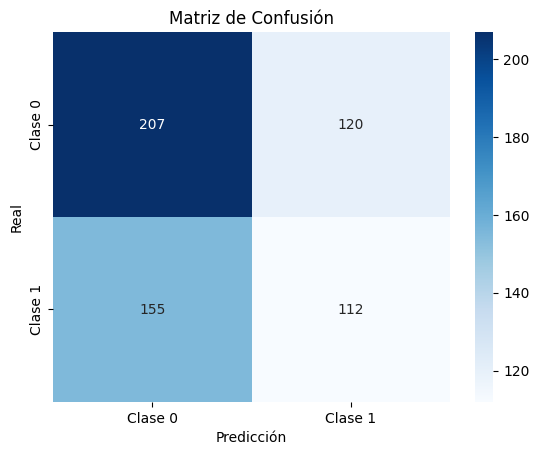

In [9]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

En la matriz de confusión podemos ver que el modelo no obtiene malos resultados cuando gana el favorito. En cambio podemos ver que hay una gran tasa de error cuando gana el no favorito o "underdog". Este desequilibrio es uno de los objetivos a paliar al realizar el ajuste de hiperparámetros.

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas.

En nuestro caso eliminamos algunas variables que no aportaban información al modelo para reducir el coste computacional.

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

Como podemos ver en nuestro modelo baseline hay problemas notables respecto a las predicciones de la Clase-1, intentaremos conseguir un mejor modelo usando las técnicas de ajuste de hiperparámetros

In [10]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)


    param_grid = {
    'n_estimators': [100, 250],
    'learning_rate': [0.01, 0.05],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.5, 0.7, 1.0],  # Añadir 0.5 para más regularización
    'gamma': [0, 0.1],  
    'min_child_weight': [10,35,50],  # Añadir 3 como punto intermedio 
    'reg_alpha': [0.1, 1.0], 
    'reg_lambda': [0.1, 1.0], 
    'scale_pos_weight': [1, scale_pos_weight]  
}


    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_,grid_search.best_params_

In [11]:
mlflow.set_experiment("Prueba con Puntos tipo elo XGBoost")

<Experiment: artifact_location='file:///c:\\Users\\mattu\\OneDrive\\Documentos\\GitHub\\c2425-R4\\mlruns/220531053739985843', creation_time=1742411979960, experiment_id='220531053739985843', last_update_time=1742411979960, lifecycle_stage='active', name='Prueba con Puntos tipo elo XGBoost', tags={}>

In [12]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid,best_params = train_xgboost_grid(X_train,y_train,X_test,y_test)


-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Mejores parámetros: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'min_child_weight': 10, 'n_estimators': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.1, 'scale_pos_weight': np.float64(1.2829643888354187), 'subsample': 1.0}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.61      0.58      0.60       327
        True       0.52      0.55      0.54       267

    accuracy                           0.57       594
   macro avg       0.57      0.57      0.57       594
weighted avg       0.57      0.57      0.57       594



In [13]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_test)
y_val_prob = best_grid.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5673400673400674
F1-Score: 0.5353
AUC-ROC: 0.5738
Precisión: 0.5175
Sensibilidad: 0.5543
Log-loss: 0.7178192777758169


Conseguimos una mejora notable respecto al modelo baseline, aumentando el accuracy alrededor de un 4%, esto nos indica que el ajuste de hiperparámetros buscando en rejilla a tenido un efecto positivo y ha funcionado correctamente. También vemos que hemos conseguido un accuracy mayor que el que se obtendría prediciendo siempre al favorito. La métrica log-loss ha mejorado notablemente respecto al modelo baseline lo que nos indica que las probabilidades que se le da a cada luchador son mucho más precisas en este modelo.

In [14]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="con k=25 y victorias/derrotas fuera de las medias, prueba con min_child_weight alto"):

    # Guardar modelo en MLflow
    mlflow.xgboost.log_model(best_grid, "modelo_xgboost")
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_val)

    print("Modelo guardado en MLflow")

c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:54:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/21 10:54:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/21 10:54:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo guardado en MLflow


Esta celda la utilizamos para guardar el modelo y poder saber cual fue el que mejor nos funcionó cuando los comparemos.

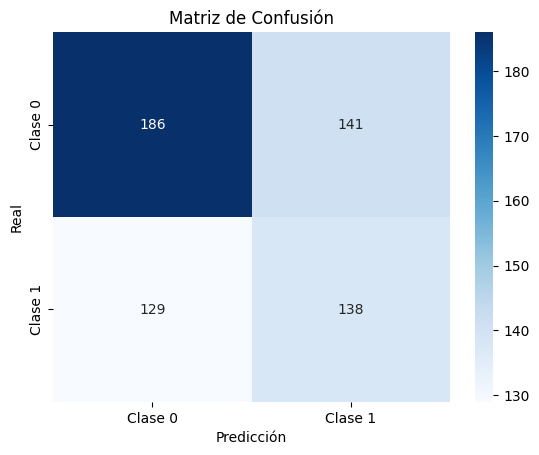

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Si observamos la matriz de confusión podemos ver que la precisión en ambas clases se ha equilibrado, mejorando notablemente las predicciones en los combates que gana el no favorito.

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                 Feature  Importance
62               Racha_A    0.019523
73             CTRL_DIFF    0.018502
21          STR_HEAD_B_x    0.018499
8                  REV_A    0.016649
68               KD_DIFF    0.016217
..                   ...         ...
32      STR_DISTANCE_A_x    0.010958
52        Derrotas_Sub_A    0.010635
0                   KD_A    0.010478
48        Victorias_KO_A    0.010333
56  Victorias_Decision_B    0.008985

[74 rows x 2 columns]


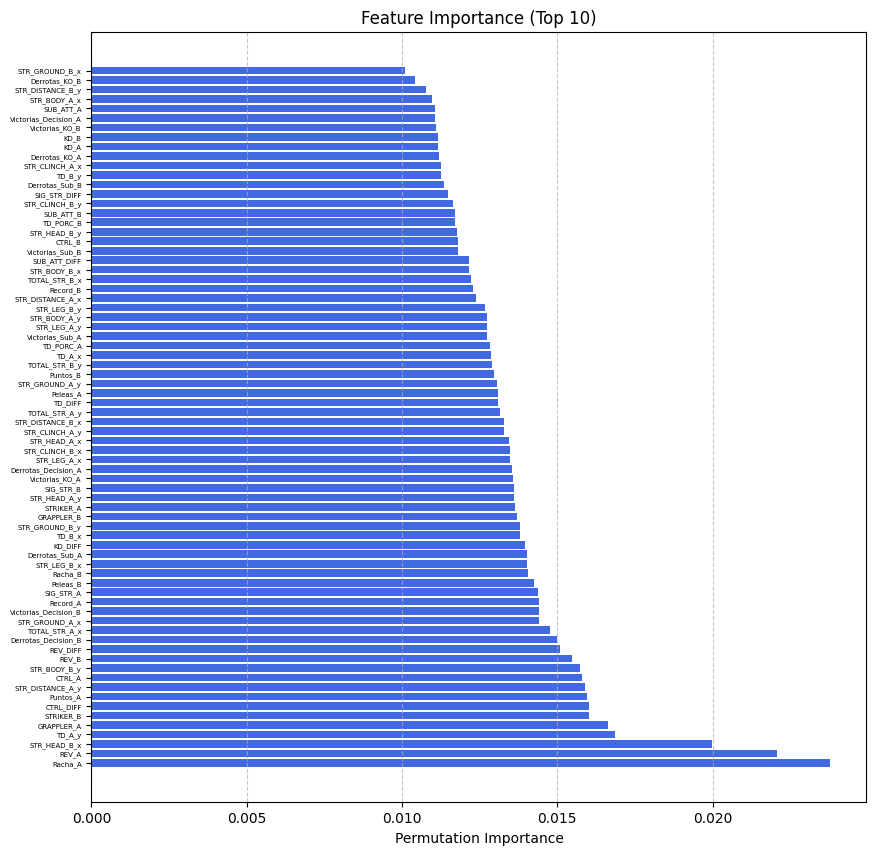

In [ ]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Podemos ver que no hay una variable a la cual se le de una gran importancia, estando todas mas o menos equilibrada. Vemos que el modelo considera la Racha del peleador A como la variable más importante.

#### Random Search

In [21]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    """
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 60, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 70, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }"
    """
    
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 40, 2),
        'learning_rate': np.linspace(0.005, 0.2, 15),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 70, 2),
        'scale_pos_weight': [1, scale_pos_weight],
        'reg_alpha': [0, 0.1, 0.5, 1], #Parámetro regularización
        'tree_method': ['auto', 'exact', 'approx', 'hist'], #Método construcción árbol
        'grow_policy': ['depthwise', 'lossguide'] #Política crecimiento árbol
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')
    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))


    return random_search

In [22]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
resultados_random = train_xgboost_random(X_train,y_train,X_test,y_test)
best_random = resultados_random.best_estimator_
results_cv = resultados_random.cv_results_

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'tree_method': 'approx', 'subsample': np.float64(0.5), 'scale_pos_weight': np.float64(1.2829643888354187), 'reg_alpha': 0.1, 'n_estimators': np.int64(200), 'min_child_weight': np.int64(21), 'max_depth': np.int64(7), 'learning_rate': np.float64(0.13035714285714287), 'grow_policy': 'depthwise', 'gamma': np.float64(0.30000000000000004), 'colsample_bytree': np.float64(0.6)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.59      0.57      0.58       327
        True       0.49      0.52      0.51       267

    accuracy                           0.55       594
   macro avg       0.54      0.54      0.54       594
weighted avg       0.55      0.55      0.55       594



In [23]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_test)
y_val_prob = best_random.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_test, y_val_pred))

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5454545454545454
F1-Score: 0.5073
AUC-ROC: 0.5664
Precisión: 0.4947
Sensibilidad: 0.5206
Log-loss: 0.7611383205505062
[[185 142]
 [128 139]]


Obtenemos un resultado notablemente peor que en la búsqueda con rejilla. El modelo es ligeramente mejor que el modelo baseline. También debemos tener en cuenta que el coste computacional ha sido notablemente menor que en la búsqueda en rejilla.

In [19]:
df_cv_results = pd.DataFrame(results_cv)
df_cv_results = df_cv_results.sort_values(by="rank_test_score")
df_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,1.120617,0.595345,0.049100,0.008927,0.8,1.290583,250,37,6,0.031111,...,0.8,"{'subsample': 0.8, 'scale_pos_weight': 1.29058...",0.525045,0.550201,0.536205,0.557391,0.571374,0.548043,0.016158,1
49,0.403807,0.167154,0.047841,0.015708,0.6,1.290583,50,19,21,0.094444,...,0.8,"{'subsample': 0.6, 'scale_pos_weight': 1.29058...",0.542219,0.544289,0.548317,0.551052,0.546122,0.546400,0.003077,2
0,2.875217,1.075932,0.063626,0.010926,1.0,1.290583,250,23,27,0.031111,...,0.6,"{'subsample': 1.0, 'scale_pos_weight': 1.29058...",0.501940,0.541100,0.557952,0.575964,0.554269,0.546245,0.024795,3
29,0.834404,0.363453,0.047628,0.011468,0.8,1.290583,200,33,18,0.136667,...,0.8,"{'subsample': 0.8, 'scale_pos_weight': 1.29058...",0.526020,0.534382,0.536318,0.552520,0.567794,0.543407,0.014912,4
32,0.622710,0.261988,0.052772,0.009667,0.9,1.290583,50,13,9,0.200000,...,0.7,"{'subsample': 0.9, 'scale_pos_weight': 1.29058...",0.493614,0.535044,0.550850,0.564471,0.572090,0.543214,0.027824,5


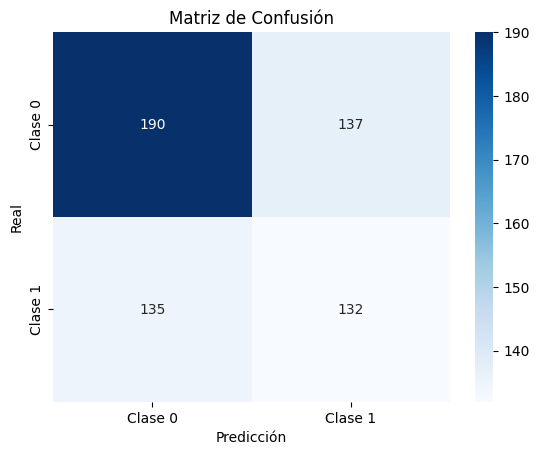

In [18]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Podemos ver en la matriz de confusión que, aunque el accuracy no sea mucho mejor que en el modelo base, la detección de casos en las que pierde el luchador favorito ha mejorado respecto el modelo baseline.

In [19]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                 Feature  Importance
8                  REV_A    0.024466
62               Racha_A    0.020314
9                  REV_B    0.017664
72              REV_DIFF    0.017421
6              SUB_ATT_A    0.016325
..                   ...         ...
17                TD_B_x    0.011180
53  Victorias_Decision_B    0.011172
40        STR_GROUND_A_x    0.010990
14         TOTAL_STR_A_y    0.010469
23          STR_HEAD_B_y    0.010259

[74 rows x 2 columns]


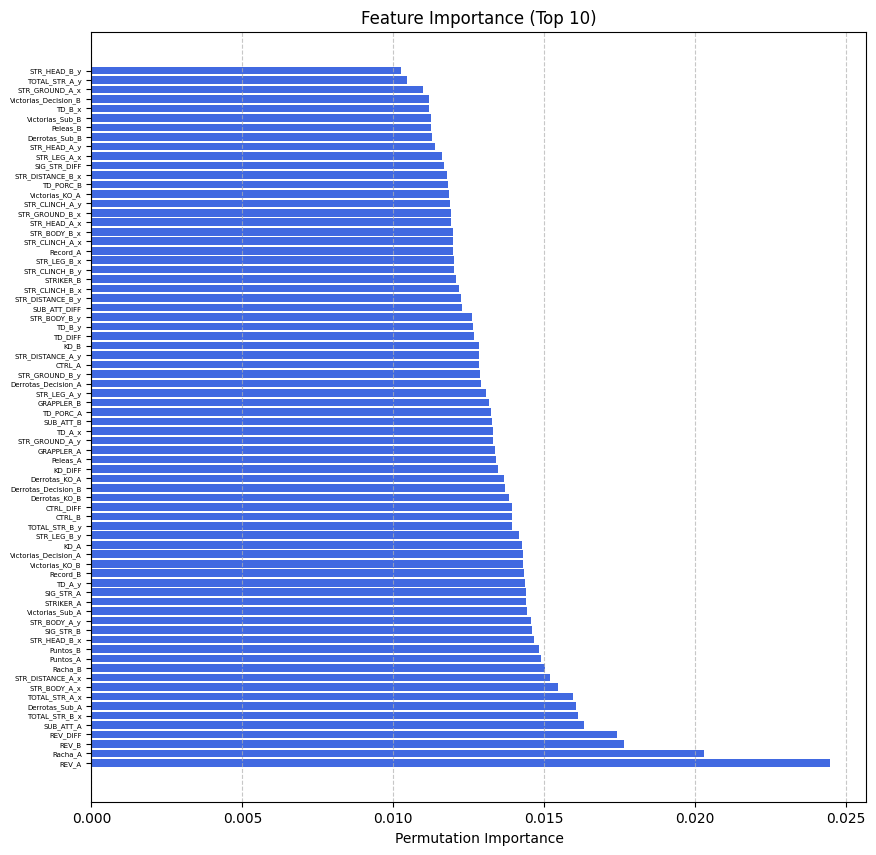

In [20]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Vemos que las variables a las que se le da importancia son similares a la de la búsqueda en rejilla intercambiando el orden de algunas. Se mantiene la similitud entre importancia entre las variables.

#### CONCLUSIONES

Tras comparar ambas estrategias, observamos que GridSearchCV tiende a encontrar combinaciones de hiperparámetros más óptimas para mejorar el F1-score, ya que evalúa exhaustivamente todas las posibles combinaciones. Sin embargo, esto conlleva un mayor coste computacional. Por otro lado, RandomizedSearchCV, aunque no explora todas las combinaciones, logra un resultado competitivo con un tiempo de ejecución significativamente menor. En este caso, si bien el modelo obtenido con RandomizedSearchCV muestra un F1-score algo inferior, ha destacado en otras métricas como el accuracy, lo que sugiere que puede ser una alternativa eficiente dependiendo de las restricciones computacionales y los objetivos del modelo.

Hemos conseguido mejorar el resultado del modelo baseline lo cual nos indica que los ajustes de hiperparámetros han sido correctos. 
No hemos conseguido obtener buenos resultados en temas de accuracy, consideramos que esto se debe a que al realizar las medias ponderadas muchos datos no son tan representativos y no tienen gran relación con el ganador de un futuro combate. A esta conclusión llegamos viendo que la importancia de las variables es bastante baja y muchas variables pierden mucha importancia respecto al modelo con datos reales de peleas.